# Prediction with Captions using embeding layer

In [1]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


/home/wsun3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df

In [3]:
# load the captions
cap_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/me18me-devset/dev-set/dev-set_video-captions.txt'
#cap_path = '/media/stone/Data/DataSet_me18me/me18me-devset/dev-set/dev-set_video-captions.txt'
df_cap=read_caps(cap_path)

# load the ground truth values
label_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/me18me-devset/dev-set/ground-truth/'
labels=pd.read_csv(label_path+'ground-truth_dev-set.csv')

counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())
    
df_cap.head()

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


,video,caption
0,video10.webm,couple relaxing on picnic crane shot
1,video100.webm,cute black and white cats in cage at animal sh...
2,video10000.webm,owl in tree close up
3,video10001.webm,around the house on a laptop
4,video10002.webm,beautiful young girl with apple


## Vectorize the captions

In [4]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
tokenizer.fit_on_texts(list(df_cap.caption.values))
sequences = tokenizer.texts_to_sequences(list(df_cap.caption.values))
sequences[:2]

[[15, 117, 3, 597, 347, 25], [136, 104, 4, 82, 1151, 1, 380, 9, 410, 411]]

In [5]:
from keras import preprocessing

In [6]:
maxlen = 10
X_seq = preprocessing.sequence.pad_sequences(sequences,maxlen=maxlen)

In [7]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = X_seq

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

In [10]:
model = Sequential()
model.add(Embedding(1+X.max(),8,input_length=maxlen))
model.add(Flatten())
model.add(Dense(10,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.002)))
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='mse',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 8)             46992     
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                810       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 47,824
Trainable params: 47,824
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(X_train,Y_train,epochs=10,batch_size=32,validation_data=(X_test,Y_test))

Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 1s 87us/step - loss: 0.1233 - acc: 0.4895 - val_loss: 0.0425 - val_acc: 0.6887
Epoch 2/10
6400/6400 [==============================] - 0s 75us/step - loss: 0.0263 - acc: 0.7028 - val_loss: 0.0176 - val_acc: 0.6956
Epoch 3/10
6400/6400 [==============================] - 0s 68us/step - loss: 0.0152 - acc: 0.7039 - val_loss: 0.0144 - val_acc: 0.6956
Epoch 4/10
6400/6400 [==============================] - 0s 65us/step - loss: 0.0143 - acc: 0.7039 - val_loss: 0.0143 - val_acc: 0.6956
Epoch 5/10
6400/6400 [==============================] - 0s 56us/step - loss: 0.0143 - acc: 0.7039 - val_loss: 0.0143 - val_acc: 0.6956
Epoch 6/10
6400/6400 [==============================] - 0s 57us/step - loss: 0.0143 - acc: 0.7039 - val_loss: 0.0143 - val_acc: 0.6956
Epoch 7/10
6400/6400 [==============================] - 0s 62us/step - loss: 0.0143 - acc: 0.7039 - val_loss: 0.0143 - val_acc: 0.6956
Epoch 8

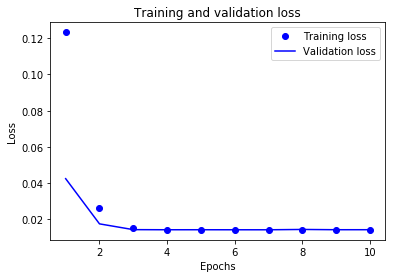

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

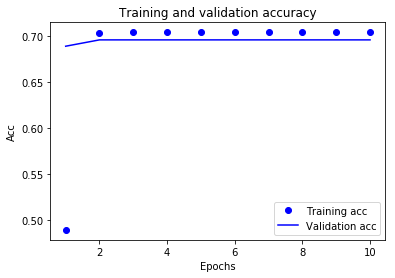

In [13]:
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


## Adding Recurrent layer to capture the order of the words

In [14]:
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(1+X.max(),15,input_length=maxlen))
#model.add(Flatten())
model.add(SimpleRNN(10))
model.add(Dense(10,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.004)))
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='mse',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 15)            88110     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                260       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total params: 88,502
Trainable params: 88,502
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train,Y_train,epochs=10,batch_size=32,validation_data=(X_test,Y_test))

Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 1s 194us/step - loss: 0.0897 - acc: 0.4253 - val_loss: 0.0445 - val_acc: 0.6950
Epoch 2/10
6400/6400 [==============================] - 1s 154us/step - loss: 0.0310 - acc: 0.7038 - val_loss: 0.0214 - val_acc: 0.6956
Epoch 3/10
6400/6400 [==============================] - 1s 155us/step - loss: 0.0177 - acc: 0.7039 - val_loss: 0.0159 - val_acc: 0.6956
Epoch 4/10
6400/6400 [==============================] - 1s 156us/step - loss: 0.0151 - acc: 0.7039 - val_loss: 0.0150 - val_acc: 0.6956
Epoch 5/10
6400/6400 [==============================] - 1s 156us/step - loss: 0.0143 - acc: 0.7039 - val_loss: 0.0144 - val_acc: 0.6956
Epoch 6/10
6400/6400 [==============================] - 1s 161us/step - loss: 0.0138 - acc: 0.7039 - val_loss: 0.0143 - val_acc: 0.6956
Epoch 7/10
6400/6400 [==============================] - 1s 159us/step - loss: 0.0134 - acc: 0.7039 - val_loss: 0.0145 - val_acc: 0.6956


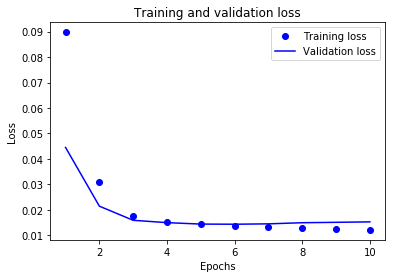

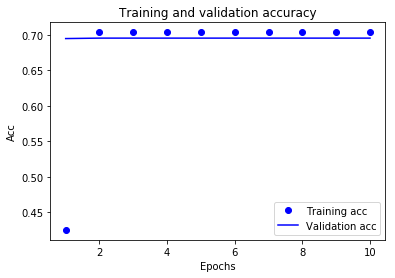

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()